Galaxies and Observational Cosmology: Assignment 2 - Galactic Rotation Curves

Alex Kusmirek [20203284]

In [1]:
#standard libraries
import sys
import time
import os

#3rd part libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy as ap
from astropy.table import Table
from tkinter import filedialog
from tkinter import *
import warnings
import math

#constants
R0 = 2.6 * 10**17 #km
V0 = 220 #km/s
c = 299792 #km/s
HI_line = 1420.406 #MHz

Task 1: Generate a rotation curve for the galaxy using the radio data provided.

This notebook details the steps taken to develop a script capable of generating a rotation curve using data provided by the University of Sydney, to complete Task 1 of the assignment.

Firstly, defining the equations for distance from galactic centre (R) and radial velocity (v) as functions:

In [2]:
#Converting galactic longitude l to distance from galactic centre R:
def l_to_R(l):
    
    L = math.radians(l)
    R = R0 * math.sin(L)
    
    return R

#Convert measured frequency f (from Sydney, 2017) into a radial velocity v:
def f_to_v(f, v_LSR):
    
    v = (((float(HI_line) - f) * float(c)) / (float(HI_line))) - v_LSR
    
    return v

Additionally, it is necessary to define a function to calculate rotational velocity based on an estimate of the most negative radial velocity for a galactic longitude:

A smoothing function is also used for producing a smoothed data plot:

In [3]:
def calc_Vrot(v_max_values, l_values):
    
    Vrot = vmax + (V0 * math.sin(math.radians(R)))
    
    return Vrot
    

In [4]:
def smooth(y, box_pts):
    
    box = np.ones(box_pts)/box_pts
    y_smoothed = np.convolve(y, box, mode = 'same')
    
    return y_smoothed


For each .txt data file (corresponding to different values of l), it is necessary to plot the radial velocity v for each channel. The code progresses through raw, then calibrated, data, resulting in a raw data plot and a calibrated, filtered and smoothed data plot:

In [5]:
def parse_data():
    
    #------------------
    # PARSING DATA FILES
    #------------------
    
    root = Tk()
    root.data_1 = filedialog.askopenfilename(initialdir = "Radio_Rot_Curve_Data_2019-20210322T105008Z-001/Radio_Rot_Curve_Data_2019",
                                             title = "Select Data 1",
                                             filetypes = (("dat files",
                                                           "*.txt"),
                                                          ("all files","*.*")))
    
    data_1 = root.data_1
    root.destroy()

    data = Table.read(data_1, format='ascii')
    
    #Setting initial calibration conditions and empty lists:
    S_off = 0
    S_off_cal = 0
    T_cal = 20 #K
    S_values = []
    v_values = []
    
    #Selecting the relative velocity to the Local Standard of Rest (v_LSR):
    file = open(data_1)
    all_data = file.readlines()
    LSR = all_data[3].split(' ')
    LSR_str = LSR[3]
    v_LSR = float(LSR_str)
    print("v_LSR = ", v_LSR)
    
    for line in data:
        
        #Separating the data values:
        # 0. OnFreq, 1. On, 2. OffFreq, 3. Off, 4. Cal
        on_freq = line[0]
        on = line[1]
        off_freq = line[2]
        off = line[3]
        cal = line[4]

        #Calibration and sigmas
        cal_off = cal - off
        S_off += off
        S_off_cal += cal_off
        
    #Calculating T_sys:
    T_sys = (S_off/(S_off_cal)) * T_cal
     
    for line in data:
        
        #Separating the data values:
        # 0. OnFreq, 1. On, 2. OffFreq, 3. Off, 4. Cal
        on_freq = line[0]
        on = line[1]
        off_freq = line[2]
        off = line[3]
        cal = line[4]
        
        #Calibration signal:
        S = (on/off) * T_sys
        S_values.append(S)
        
        #Use f_to_v function to calculate v:
        v_values.append(f_to_v(line[0], v_LSR))
        
    #------------------
    # PLOTTING GRAPHS
    #------------------

    #Plotting the signal frequency (converted to radial velocity) vs. intensity:
    plt.plot(f_to_v(data.columns[0], v_LSR), data.columns[1], color = 'black')
    plt.xlabel("Radial velocity, $\it{v}$ (km/s)")
    plt.ylabel("Intensity, $\it{I}$")
    plt.title("Raw Signal")
    plt.show()
    
    #Plotting a calibrated, filtered and smoothed curve using Tsys and sigmas:
    
    #filtering the signal to the area of interest around the 1420MHz HI line:
    
    #lists to plot on graph:
    S_graph = smooth(S_values, 20)
    v_graph = v_values
    
    plt.plot(v_graph, S_graph, color = 'black')
    plt.xlabel("Radial velocity, $\it{v}$ (km/s)")
    plt.ylabel("Intensity, $\it{I}$")
    plt.title("Calibrated Signal")
    plt.xlim(-500,500)
    plt.show()  
    

Below is an example of the raw and calibrated graphs for a selected file (recommended to select '10.txt' for l = 10):

v_LSR =  -40.4644


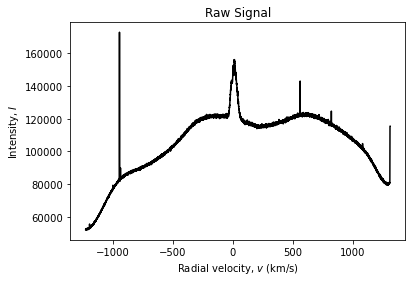

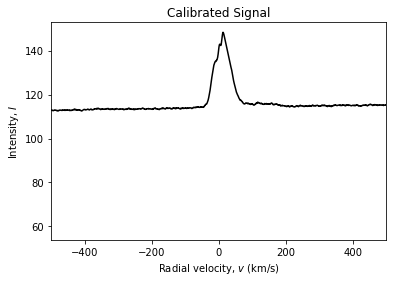

In [6]:
parse_data()

From the calibrated signal, a vmax can be estimated either by a 5-sigma approximation of the most negative velocity or as a visual estimate.

Having run the parse_data() function to find a vmax estimate, the code can now calculate a rotational velocity (Vrot) value for the .txt data file that has been accessed, alongside the appropriate R value for the file's longitude l. Values for the most negative velocity (vmax) are estimated for each data file, and these are used to calculate Vrot using the function calc_Vrot(vmax). To calculate a rotation curve, the functions are looped to allow the analyst to select each data file in turn and output the necessary values.

Values are automatically printed and recorded in a results file to allow for easy manipulation by the analyst.

The following list of v_max values was estimated using the parse_data() function:

In [7]:
v_max_values = [50, 60, 75, 80,
                90, 100, 140, 150,
                150, 150, 150, 125,
                125, 125, 125, 115,
                115, 100, 100, 100,
                90, 85, 80, 75,
                75, 75, 70, 60,
                60, 60, 60, 50,
                50, 50, 45, 50,
                40, 40, 40, 35,
                35, 30, 30, 30]

v_max_values is then used to in a loop to calculate values of Vrot using the function calc_Vrot(v_max_values) and the provided list of l values:

In [8]:
#opening and parsing the LSR file:
LSR_file = open("Radio_Rot_Curve_Data_2019-20210322T105008Z-001/Radio_Rot_Curve_Data_2019/LSR.txt")
LSR_file_data = LSR_file.readlines()
l_LSR = LSR_file_data[3:]

#empty longitude list
l_list = []

#Listing the l values that correlate to the v_max_values list:
for row in l_LSR:
    
    l_LSR_stripped = row.strip().split(' ')
    l_string = l_LSR_stripped[0]
    l_degrees = float(l_string)
    l = math.radians(l_degrees)
    l_list.append(l)


In [9]:
R_values = []
Vrot_values = []

for i in range(len(v_max_values)):
    
    v_max = v_max_values[i]
    l = l_list[i]
    
    R = R0 * (math.sin(l))
    Vrot = v_max + (V0 * math.sin(l))
    
    R_values.append(R)
    Vrot_values.append(Vrot)


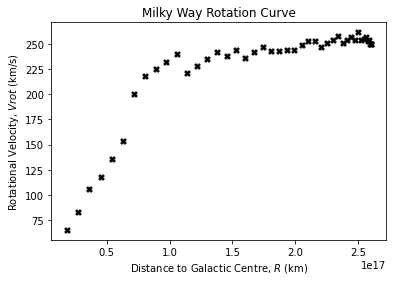

In [10]:
#Plotting Vrot vs. R (our galactic rotation curve):
plt.scatter(R_values, Vrot_values, marker ='X', c = 'black', linewidth = 0.5)
plt.title('Milky Way Rotation Curve')
plt.xlabel('Distance to Galactic Centre, $\it{R}$ (km)')
plt.ylabel('Rotational Velocity, $\it{Vrot}$ (km/s)')
plt.show()

Using the results of Vrot for each value of l observed, a Milky Way rotation curve has been generated for l = 4:90 degrees.